
# Prediction with a pre-trained model 

In [1]:
from keras.models import load_model
from unet3 import *

# load json and create model 
json_file = open('model/model3.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model/pretrained_model.hdf5")
print("Loaded model from disk")

# training image dimensions
n1, n2, n3 = 128, 128, 128

Loaded model from disk


In [2]:
# set gaussian weights in the overlap bounaries
def getMask(os):
    sc = np.zeros((n1,n2,n3),dtype=np.single)
    sc = sc+1
    sp = np.zeros((os),dtype=np.single)
    sig = os/4
    sig = 0.5/(sig*sig)
    for ks in range(os):
        ds = ks-os+1
        sp[ks] = np.exp(-ds*ds*sig)
    for k1 in range(os):
        for k2 in range(n2):
            for k3 in range(n3):
                sc[k1][k2][k3]=sp[k1]
                sc[n1-k1-1][k2][k3]=sp[k1]
    for k1 in range(n1):
        for k2 in range(os):
            for k3 in range(n3):
                sc[k1][k2][k3]=sp[k2]
                sc[k1][n3-k2-1][k3]=sp[k2]
    for k1 in range(n1):
        for k2 in range(n2):
            for k3 in range(os):
                sc[k1][k2][k3]=sp[k3]
                sc[k1][k2][n3-k3-1]=sp[k3]
    return sc

def predictWithMask(gx):
    os = 12 #overlap width
    c1 = np.round((m1+os)/(n1-os)+0.5)
    c2 = np.round((m2+os)/(n2-os)+0.5)
    c3 = np.round((m3+os)/(n3-os)+0.5)
    c1 = int(c1)
    c2 = int(c2)
    c3 = int(c3)
    p1 = (n1-os)*c1+os
    p2 = (n2-os)*c2+os
    p3 = (n3-os)*c3+os
    gx = np.reshape(gx,(m1,m2,m3))
    gp = np.zeros((p1,p2,p3),dtype=np.single)
    gy = np.zeros((p1,p2,p3),dtype=np.single)
    mk = np.zeros((p1,p2,p3),dtype=np.single)
    gs = np.zeros((1,n1,n2,n3,1),dtype=np.single)
    gp[0:m1,0:m2,0:m3]=gx
    sc = getMask(os)
    for k1 in range(c1):
        for k2 in range(c2):
            for k3 in range(c3):
                b1 = k1*n1-k1*os
                e1 = b1+n1
                b2 = k2*n2-k2*os
                e2 = b2+n2
                b3 = k3*n3-k3*os
                e3 = b3+n3
                gs[0,:,:,:,0]=gp[b1:e1,b2:e2,b3:e3]
                gs = gs-np.min(gs)
                gs = gs/np.max(gs)
                gs = gs*255 
                Y = loaded_model.predict(gs,verbose=1)
                Y = np.array(Y)
                gy[b1:e1,b2:e2,b3:e3]= gy[b1:e1,b2:e2,b3:e3]+Y[0,:,:,:,0]*sc
                mk[b1:e1,b2:e2,b3:e3]= mk[b1:e1,b2:e2,b3:e3]+sc
    gy = gy/mk
    gy = gy[0:m1,0:m2,0:m3]
    return gx, gy

def stdMin(gx):
    gm = np.mean(gx)
    gs = np.std(gx)
    gx = gx-gm
    gx = gx/gs
    return gx

 
## ======================================================================

## prediction test on a field seismic image extracted from

## Valdemar dataset

In [3]:
import matplotlib.pyplot as plt
import segyio
%matplotlib inline

seismPath = 'C:/Users/vwt756/OneDrive - GEUS/MLO documents/pythoncode_local/LOCRETA/data/seismic/Valdemar_full_stack_scaled_1.sgy' #"E:/ForVideoSegy/CanningCut.segy"
gx = segyio.tools.cube(seismPath)
print (gx.shape)
fault_dummy = np.zeros(gx.shape)
#gx= gx[:, :, :256]
gx= gx[:, :, 90:346]
m1,m2, m3 = gx.shape[0], gx.shape[1], gx.shape[2]
gx = stdMin(gx)
print (gx.shape)
gx, gy = predictWithMask(gx)

(301, 351, 376)
(301, 351, 256)
1/1 [==============================] - 3s 3s/step


In [4]:
1.5 + (120*0.004)

1.98

In [5]:
gy.shape

(301, 351, 256)

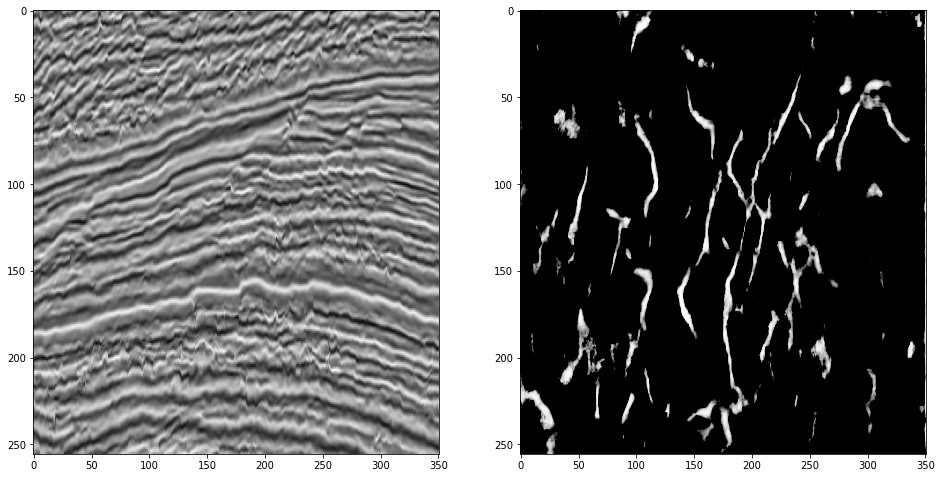

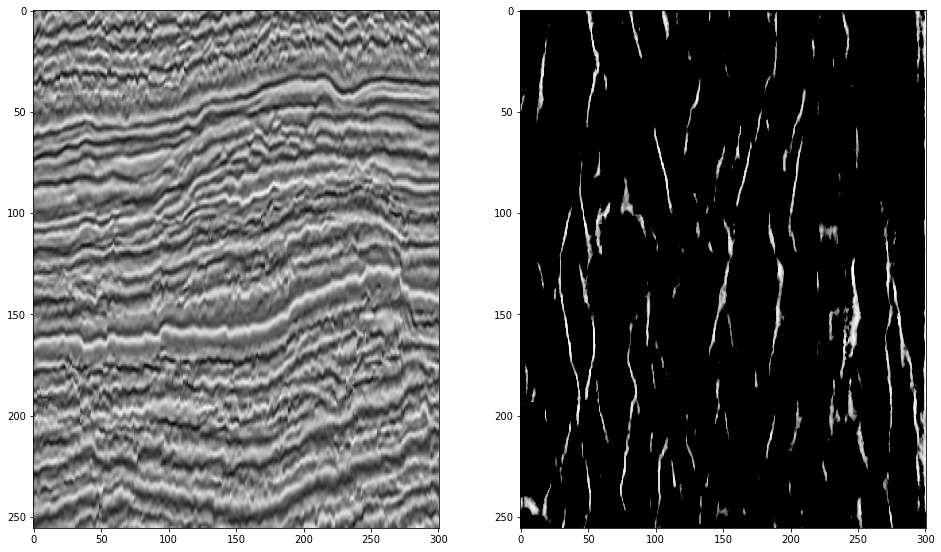

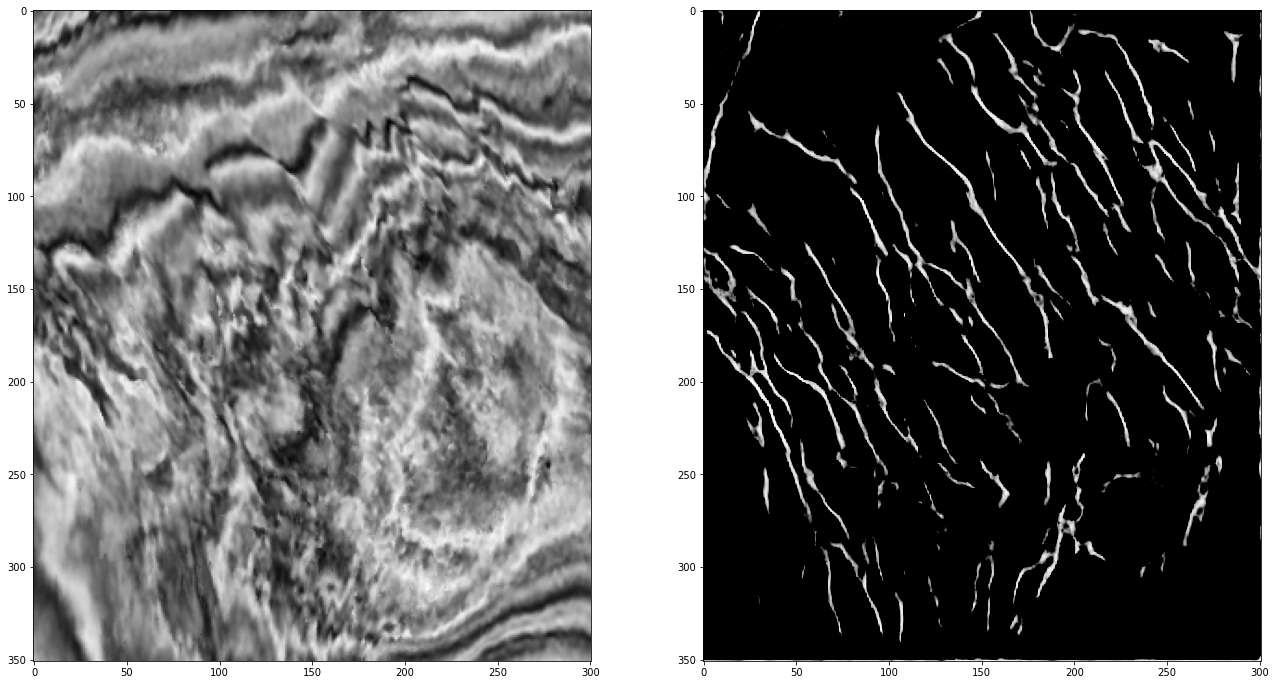

In [6]:
from matplotlib.colors import Normalize
from PIL import Image
#gx,m1,m2,m3 = np.fromfile("data/prediction/f3d/gxl.dat",dtype=np.single),512,384,128
#gy.tofile("data/prediction/f3d/"+"fp.dat",format="%4")

gx = np.reshape(gx,(m1,m2,m3))
gy = np.reshape(gy,(m1,m2,m3))

k1,k2,k3 = 150,250,110
gx1 = np.transpose(gx[k1,:,:])
gy1 = np.transpose(gy[k1,:,:])
gx2 = np.transpose(gx[:,k2,:])
gy2 = np.transpose(gy[:,k2,:])
gx3 = np.transpose(gx[:,:,k3])
gy3 = np.transpose(gy[:,:,k3])

#xline slice
fig = plt.figure(figsize=(16,16))
p1 = plt.subplot(1, 2, 1)
p1.imshow(gx1,aspect=1.5,cmap=plt.cm.gray)
p2 = plt.subplot(1,2,2)
p2.imshow(gy1,aspect=1.5,interpolation="bilinear",vmin=0.9,vmax=1.0,cmap=plt.cm.gray)

#inline slice
fig = plt.figure(figsize=(16,16))
p1 = plt.subplot(1, 2, 1)
p1.imshow(gx2,aspect=1.5,cmap=plt.cm.gray)
p2 = plt.subplot(1,2,2)
p2.imshow(gy2,aspect=1.5,interpolation="bilinear",vmin=0.9,vmax=1.0,cmap=plt.cm.gray)

#time slice
fig = plt.figure(figsize=(22,22))
p1 = plt.subplot(1, 2, 1)
p1.imshow(gx3,cmap=plt.cm.gray)
p2 = plt.subplot(1,2,2)
p2.imshow(gy3,interpolation="bilinear",vmin=0.9,vmax=1.0,cmap=plt.cm.gray)

In [7]:
gx.max()

3.1772263

In [8]:
gy.shape

(301, 351, 256)

In [9]:
fault_dummy[:,:,90:346] = gy

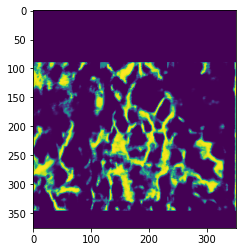

In [10]:
plt.imshow(fault_dummy[40,:,:].T)

In [11]:
valdemar =  seismPath
from segysak.segy import segy_loader
valdemar = segy_loader(valdemar ,cdp=None, iline=189, xline=193,cdpx=181, cdpy = 185,  vert_domain='TWT', data_type='AMP')

C:\Users\vwt756\Anaconda3\lib\site-packages\segysak\segy\_segy_core.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0.00/106k [00:00<?, ? traces/s]

Loading as 3D
Fast direction is INLINE_3D


Converting SEGY:   0%|          | 0.00/106k [00:00<?, ? traces/s]

In [12]:
processed_dummy = stdMin(valdemar.data.data)

In [13]:

dim = valdemar.data.shape
idx = np.arange(0, dim[0])
print(np.amin(idx), np.amax(idx))

lns = np.arange(np.amin(valdemar.data.iline), np.amax(valdemar.data.iline)+1,2)
print(np.amin(lns), np.amax(lns))

0 300
7900 8500


In [14]:
lns

array([7900, 7902, 7904, 7906, 7908, 7910, 7912, 7914, 7916, 7918, 7920,
       7922, 7924, 7926, 7928, 7930, 7932, 7934, 7936, 7938, 7940, 7942,
       7944, 7946, 7948, 7950, 7952, 7954, 7956, 7958, 7960, 7962, 7964,
       7966, 7968, 7970, 7972, 7974, 7976, 7978, 7980, 7982, 7984, 7986,
       7988, 7990, 7992, 7994, 7996, 7998, 8000, 8002, 8004, 8006, 8008,
       8010, 8012, 8014, 8016, 8018, 8020, 8022, 8024, 8026, 8028, 8030,
       8032, 8034, 8036, 8038, 8040, 8042, 8044, 8046, 8048, 8050, 8052,
       8054, 8056, 8058, 8060, 8062, 8064, 8066, 8068, 8070, 8072, 8074,
       8076, 8078, 8080, 8082, 8084, 8086, 8088, 8090, 8092, 8094, 8096,
       8098, 8100, 8102, 8104, 8106, 8108, 8110, 8112, 8114, 8116, 8118,
       8120, 8122, 8124, 8126, 8128, 8130, 8132, 8134, 8136, 8138, 8140,
       8142, 8144, 8146, 8148, 8150, 8152, 8154, 8156, 8158, 8160, 8162,
       8164, 8166, 8168, 8170, 8172, 8174, 8176, 8178, 8180, 8182, 8184,
       8186, 8188, 8190, 8192, 8194, 8196, 8198, 82

In [15]:
import segyio

In [16]:
from shutil import copyfile
input_file = seismPath
output_file =  "C:/Users/vwt756/OneDrive - GEUS/MLO documents/pythoncode_local/LOCRETA/data/seismic/Valdemar_faults_review.sgy"

copyfile(input_file, output_file)
#iline=189, xline=193,cdpx=181, cdpy = 185
with segyio.open(output_file,  "r+", iline=189, xline=193) as dst:
    for i,j in zip(lns,idx):
        dst.iline[i] = fault_dummy[j,:,:]

C:\Users\vwt756\Anaconda3\lib\site-packages\segyio\utils.py:23: RuntimeWarning: Implicit conversion from float64 to float32 (narrowing)
  warnings.warn(msg.format(x.dtype, dtype), RuntimeWarning)


In [17]:
from shutil import copyfile
input_file = seismPath
output_file =  "C:/Users/vwt756/OneDrive - GEUS/MLO documents/pythoncode_local/LOCRETA/data/seismic/Valdemar_processedcube_review.sgy"

copyfile(input_file, output_file)
#iline=189, xline=193,cdpx=181, cdpy = 185
with segyio.open(output_file,  "r+", iline=189, xline=193) as dst:
    for i,j in zip(lns,idx):
        dst.iline[i] = processed_dummy[j,:,:]

In [18]:
valdemar

<xarray.Dataset>
Dimensions:  (iline: 301, xline: 351, twt: 376)
Coordinates:
  * iline    (iline) uint16 7900 7902 7904 7906 7908 ... 8494 8496 8498 8500
  * xline    (xline) uint16 7800 7801 7802 7803 7804 ... 8147 8148 8149 8150
  * twt      (twt) float64 1.5e+03 1.504e+03 1.508e+03 ... 2.996e+03 3e+03
    cdp_x    (iline, xline) float32 5.953e+05 5.953e+05 ... 5.997e+05 5.997e+05
    cdp_y    (iline, xline) float32 6.179e+06 6.179e+06 ... 6.186e+06 6.186e+06
Data variables:
    data     (iline, xline, twt) float32 269.1 -653.1 -1.298e+03 ... 91.93 0.0
Attributes: (12/13)
    ns:                  None
    sample_rate:         4.0
    text:                C 1 DATE: 01/09/2021\nC 2 AN INCREASE IN AMPLITUDE E...
    measurement_system:  m
    d3_domain:           None
    epsg:                None
    ...                  ...
    corner_points_xy:    None
    source_file:         Valdemar_full_stack_scaled_1.sgy
    srd:                 None
    datatype:            None
    percentiles:         [-2206.9209288469647, -2150.4108361795716, -1289.990...
    coord_scalar:        -100.0

In [19]:
cube =  "C:/Users/vwt756/OneDrive - GEUS/MLO documents/pythoncode_local/LOCRETA/data/seismic/Valdemar_faults_review.sgy"
from segysak.segy import segy_loader
cnn = segy_loader(cube ,cdp=None, iline=189, xline=193,cdpx=181, cdpy = 185,  vert_domain='TWT', data_type='AMP')

  0%|          | 0.00/106k [00:00<?, ? traces/s]

Loading as 3D
Fast direction is INLINE_3D


Converting SEGY:   0%|          | 0.00/106k [00:00<?, ? traces/s]

In [20]:
#stenlille["CNN"] = (("iline", "xline", "twt"), fault_dummy)

In [21]:
cnn

<xarray.Dataset>
Dimensions:  (iline: 301, xline: 351, twt: 376)
Coordinates:
  * iline    (iline) uint16 7900 7902 7904 7906 7908 ... 8494 8496 8498 8500
  * xline    (xline) uint16 7800 7801 7802 7803 7804 ... 8147 8148 8149 8150
  * twt      (twt) float64 1.5e+03 1.504e+03 1.508e+03 ... 2.996e+03 3e+03
    cdp_x    (iline, xline) float32 5.953e+05 5.953e+05 ... 5.997e+05 5.997e+05
    cdp_y    (iline, xline) float32 6.179e+06 6.179e+06 ... 6.186e+06 6.186e+06
Data variables:
    data     (iline, xline, twt) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes: (12/13)
    ns:                  None
    sample_rate:         4.0
    text:                C 1 DATE: 01/09/2021\nC 2 AN INCREASE IN AMPLITUDE E...
    measurement_system:  m
    d3_domain:           None
    epsg:                None
    ...                  ...
    corner_points_xy:    None
    source_file:         Valdemar_faults_review.sgy
    srd:                 None
    datatype:            None
    percentiles:         [0.0, 0.0, 0.0, 0.983236171077601, 0.995389787121918...
    coord_scalar:        -100.0

In [22]:
import ipywidgets as widgets


from ipywidgets import interactive

def f(m):
    plt.figure(figsize=(15,10))
#    plt.imshow(gx[:,:,m], cmap='seismic',vmin=-5,vmax=5)
    plt.imshow(valdemar.data.data[:,m,88:600].T, cmap='seismic',) # alpha=0.5,# vmin=.60,vmax=1)
    plt.imshow(cnn.data.data[:,m,88:600].T, cmap='Greys',alpha=.5,vmin=.95,vmax=1) # alpha=0.5,# vmin=.60,vmax=1)
    plt.show()

interactive_plot = interactive(f, m=(0, 470))
output = interactive_plot.children[-1]
output.layout.height = '500px'
interactive_plot

interactive(children=(IntSlider(value=235, description='m', max=470), Output(layout=Layout(height='500px'))), …